In [1]:
%%HTML
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>

In [2]:
##MF10から使える反応を抽出しuseリストをつくる
#またuseリストの順番に対応する断面積スペクトルのcrossリストも作る
p = 1
import os
import numpy as np
import math

reference = "../reference/"#プログラムで読み取るファイルを入れるフォルダ

path = reference + "jendl-ad2017_300K.tar/jendl-ad2017_300K/"
files = os.listdir(path)
Threshhold_MIN = float(5.08E+6)
Threshhold_MAX = float(7.89E+6)

spect_energy_list = []#フラックスのエネルギー値のリスト
spect_fulx_list = []#フラックスのエネルギーごとのフラックスのリスト

sigma_reaction_list = []#reaction_listの順番に対応するΣσφのリスト

# Nbの断面積スペクトルのリスト
cross_section_Nb_list = []

nist_list = []

#nistから読み取った自然界に存在する核種に関するデータを格納するリスト
natural_element_nist_list = []
natural_comp_list = []#存在比
natural_ramass_list = []#相対原子質量
natural_massnum_list = []#原子番号
natural_saw_list = []#平均質量数

#nistから読み取た自然界にないものも含めたすべての核種に関するデータを格納するリスト
element_nist_list = []
massnum_list = []

#JENDLから読み取ったMF=10の反応を格納するリスト[元素記号-原子番号、反応の種類、順位、閾値、娘核の原子番号、娘核の質量数、娘核の元素記号、存在比、平均質量数、Σσφ]
reaction_list = []

#反応ごとの断面積スペクトルのリスト
cross_section_list = []




f = open(reference + "/NIST.txt")
data1 = f.read()
f.close()
lines1 = data1.split("\n") # 改行で区切る(改行文字そのものは戻り値のデータには含まれない)

n=0
for line in lines1:
    n = n + 1
    nist_list.append(line+"  ")

f = open(reference + "/spectrum.txt")
line = f.readline()
while line:
    line = line.rstrip()
    s = line.split("\t")
    spect_energy_list.append(float(s[0]))
    spect_fulx_list.append(float(s[1]))
    line = f.readline()
f.close

def numeric(a):
    k = ""
    if a[len(a)-2] == "+" or a[len(a)-2] == "-":
        for i in range(len(a)):
            if i == len(a)-2:
                k = k + "E" + a[i]
            else:
                k = k + a[i]
        return k
    if a[len(a)-3] == "+" or a[len(a)-3] == "-":
        for i in range(len(a)):
            if i == len(a)-3:
                k = k + "E" + a[i]
            else:
                k = k + a[i]
        return k
    
    

#自然界に存在する元素を抽出------------------------------------------------------------------------------
for i in range(math.floor(len(nist_list)/8)):
    if len(nist_list[8*i+4]) != 25:#Isotopic Compositionのデータがあるとき（存在比が有意）
        if nist_list[8*i+2][15] == " ":#質量数が１桁の時
            natural_element_nist_list.append(nist_list[8*i+1][16]+nist_list[8*i+1][17]+"-"+nist_list[8*i+2][14].rjust(3))
        elif nist_list[8*i+2][16] == " ":#質量数が2桁の時
            natural_element_nist_list.append(nist_list[8*i+1][16]+nist_list[8*i+1][17]+"-"+(nist_list[8*i+2][14]+nist_list[8*i+2][15]).rjust(3))
        else:#質量数が３桁の時
            natural_element_nist_list.append(nist_list[8*i+1][16]+nist_list[8*i+1][17]+"-"+nist_list[8*i+2][14]+nist_list[8*i+2][15]+nist_list[8*i+2][16])
        
        #同位体存在比を抽出-----------------
        s=nist_list[8*i+4].split()
        comp = ""
        for k in range(len(s[3])):
            if s[3][k] == "(":
                break
            comp = comp + s[3][k]
        natural_comp_list.append(comp.ljust(10))
        
        #相対原子質量を抽出--------------------
        s = nist_list[8*i+3].split()
        ramass = ""
        for l in range(len(s[4])):
            if s[4][l] == "(":
                break
            ramass = ramass + s[4][l]
        natural_ramass_list.append(ramass)
        
        #原子番号を抽出---------------------
        natural_massnum_list.append(int(nist_list[8*i][16]+nist_list[8*i][17]+nist_list[8*i][18]))
        
        #平均原子量を抽出
        s = nist_list[8*i+5].split()
        saw = ""
        for j in range(len(s[4])):
            if s[4][j] == "(":
                break
            if s[4][j] != "[" and s[4][j] != "]":
                saw = saw + s[4][j]
        if len(saw.split(",")) == 2:
            d = saw.split(",")
            saw = (float(d[0]) + float(d[1]))/2
        natural_saw_list.append(saw)

        
#すべての元素を抽出------------------------------------------------------------------------------
for i in range(math.floor(len(nist_list)/8)):
    element_nist_list.append(nist_list[8*i+1][16]+nist_list[8*i+1][17])
        
    #原子番号を抽出---------------------
    massnum_list.append(int(nist_list[8*i][16]+nist_list[8*i][17]+nist_list[8*i][18]))

for t in files:
    path2 = reference + '/jendl-ad2017_300K.tar/jendl-ad2017_300K/'+t
    text_list = []#１行ずつテキストを格納する配列
    MF10_existence = 0#MF=10があるかどうかを識別する定数（0:なし　１:あり）
    MT_list = []#MF=10のMTが格納される配列 MF=10 MT=AAA (X,X)
    MF10Q0 = 0#基底順位のQ値を代入する変数
    MF10Q = 0#Q値を代入する変数
    MF10Qline_list = []#放射化後の核種ごとのQ値が書かれている行か格納される配列
    reaction_per_element_list = []#１つの核種のすべての反応をまとめたリスト[核種、反応、順位、閾値、娘核の原子番号、娘核の質量数、娘核の核種、存在比、平均質量]のリスト
    cross_section_per_element_list = []#反応ごとの断面積スペクトル


    num_lines = len(open(path2).readlines())#最終行を取得
    f = open(path2)
    data1 = f.read()
    f.close()
    lines1 = data1.split('\n') # 改行で区切る(改行文字そのものは戻り値のデータには含まれない)

    #１行ごとにtext_listに追加------------------------------
    n=0
    for line in lines1:
        n = n + 1
        text_list.append(line)

        #MF=10の記載があるかどうかを識別
        if line.startswith("MF=10"):#行がMF=10から始まるときMF10_existenceを1（あり）にする
            MF10_existence = 1

        #MF=10がある時
        if MF10_existence == 1:
            if line.startswith("  MT"):#行が MTから始まるとき、その行の必要な情報をMT_listに追加
                MT_list.append("MF=10 "+ line[2]+line[3]+line[4]+line[5]+line[6]+line[7]+line[8]+line[9]+line[10]+line[11]+line[12]+line[13]+line[14]+line[15]+line[16]+line[17]+line[18]+line[19]+line[20]+line[21]+line[22]+line[23]+line[24]+line[25])

        if n != num_lines + 1:
            for i in range(len(MT_list)):
                if line[70]+line[71]+line[72]+line[73]+line[74] == "10" + MT_list[i][9]+MT_list[i][10]+MT_list[i][11]:#71～74列目が10MTに一致する行（MF=10,MT=〇）
                    if line[78] + line[79] == " 2":#行末が２に一致する行（基底エネルギーが書いてある行）
                        MF10Q0 = line[0]+line[1]+line[2]+line[3]+line[4]+line[5]+line[6]+line[7]+line[8]+line[9]+line[10]
                
                    if line[0]+line[1]+line[2]+line[3]+line[4]+line[5]+line[6]+line[7]+line[8]+line[9]+line[10] == MF10Q0:#Q値が書いてある行
                        MF10Qline_list.append(n-1)




    

    #１つの核種の反応ごとのQ値などを読み取る
    #１つの核種の反応ごとにforを回している----------------------------------------------------------------
    for i in range(len(MF10Qline_list)):
        data_list = []#forループで回っている反応ごとの情報が追加されるリスト
        cross_data_list = []#forループで回っている反応ごとの断面積スペクトルが追加されるリスト
        
        k = MF10Qline_list[i]#kにQ値が書いてある行を代入
        data_list.append(text_list[0][16]+text_list[0][17]+text_list[0][18]+text_list[0][19]+text_list[0][20]+text_list[0][21])#放射化前の核種

        for j in range(len(MT_list)):
            if MT_list[j][9]+MT_list[j][10]+MT_list[j][11] == text_list[k][72]+text_list[k][73]+text_list[k][74]:
                data_list.append(MT_list[j])#反応の種類

        #Q値
        MF10Q = numeric(text_list[k][11]+text_list[k][12]+text_list[k][13]+text_list[k][14]+text_list[k][15]+text_list[k][16]+text_list[k][17]+text_list[k][18]+text_list[k][19]+text_list[k][20]+text_list[k][21])
        
        #グランドステイトのQ値
        MF10Q0 = numeric(text_list[k][0]+text_list[k][1]+text_list[k][2]+text_list[k][3]+text_list[k][4]+text_list[k][5]+text_list[k][6]+text_list[k][7]+text_list[k][8]+text_list[k][9]+text_list[k][10])
        
        #グランドステイトからの差分
        MF10dQ = (float(MF10Q0) - float(MF10Q))/1000

        data_list.append(MF10dQ)
    
        
#         Q値を追加-------------------------------------------------
        if float(MF10Q) < 0:#Q値が負の時（＝閾値がある）

            #閾値
            MF10Threshold = numeric(text_list[k+2][1]+text_list[k+2][2]+text_list[k+2][3]+text_list[k+2][4]+text_list[k+2][5]+text_list[k+2][6]+text_list[k+2][7]+text_list[k+2][8]+text_list[k+2][9]+text_list[k+2][10]+text_list[k+2][11])
            data_list.append(MF10Threshold)

        else:#Q値が正の時（＝閾値がなく、14MeV中性子に対する断面積の情報はいらない）
            data_list.append("0")#閾値がないので閾値の欄に0を追加
            
            
            
#       断面積スペクトルを取得-------------------------------------------------
        if i != len(MF10Qline_list)-1:#最終行まで
            
            #反応ごとのforが対象にしている反応を１列ずつ読む----
            for u in range(MF10Qline_list[i]+2,MF10Qline_list[i+1]):
                
                if text_list[u][76]+text_list[u][77]+text_list[u][78]+text_list[u][79] != "9999":
                    if text_list[u][78]+text_list[u][79] != " 1":
                        for a in range(len(text_list[u].split())):
                            if len(text_list[u].split()[a]) >= 8 and ("+" in text_list[u].split()[a]  or "-" in text_list[u].split()[a] ):
                                cross_data_list.append(numeric(text_list[u].split()[a][0]+text_list[u].split()[a][1]+text_list[u].split()[a][2]+text_list[u].split()[a][3]+text_list[u].split()[a][4]+text_list[u].split()[a][5]+text_list[u].split()[a][6]+text_list[u].split()[a][7]+text_list[u].split()[a][8]+text_list[u].split()[a][9]))
                                
                        
            
        else:
            
            for u in range(MF10Qline_list[i]+2,num_lines):
                if text_list[u][76]+text_list[u][77]+text_list[u][78]+text_list[u][79] == "9999":
                    break
                
                if text_list[u][76]+text_list[u][77]+text_list[u][78]+text_list[u][79] != "9999":
                    if text_list[u][78]+text_list[u][79] != " 1":
                        for a in range(len(text_list[u].split())):
                            if len(text_list[u].split()[a]) >= 8 and ("+" in text_list[u].split()[a]  or "-" in text_list[u].split()[a] ):
                                cross_data_list.append(numeric(text_list[u].split()[a][0]+text_list[u].split()[a][1]+text_list[u].split()[a][2]+text_list[u].split()[a][3]+text_list[u].split()[a][4]+text_list[u].split()[a][5]+text_list[u].split()[a][6]+text_list[u].split()[a][7]+text_list[u].split()[a][8]+text_list[u].split()[a][9]))  




        cross_section_per_element_list.append(cross_data_list)#反応ごとの断面積スペクトルを核種でまとめる
        reaction_per_element_list.append(data_list)#それぞれの反応の情報を核種でまとめる
#     print(len(reaction_per_element_list))
#     print(len(cross_section_per_element_list))


    if len(reaction_per_element_list) != 0:
        


# #         自然界にあるものかつ閾値が条件にあうものをreaction_listに追加-------------------------------
#           reaction_per_element_listでforを回して（１つの核種で反応ごとにforを回す）条件に合うものをreaction_listに追加
        for i in range(len(reaction_per_element_list)):
            for k in range(len(natural_element_nist_list)):
                if natural_element_nist_list[k] == reaction_per_element_list[i][0]:
                    if float(reaction_per_element_list[i][3]) <= Threshhold_MAX and float(reaction_per_element_list[i][3]) >= Threshhold_MIN:
                        
                        
#                         print(natural_comp_list[k],natural_massnum_list[k],reaction_per_element_list[i])#じぶんで書いた以下の反応のif分に漏れがないか調べるためのprint

                        p = p + 1
                        cross_section_list.append(cross_section_per_element_list[i])#reaction_per_element_listが条件を満たすときその断面積スペクトルをcross_section_listに追加
    
                        if  "(n,He3)" in reaction_per_element_list[i][1]:
                            for j in range(len(massnum_list)):
                                if massnum_list[j] == natural_massnum_list[k]-2:
                                    reaction_per_element_list[i].append(natural_massnum_list[k]-2)
                                    reaction_per_element_list[i].append(int(reaction_per_element_list[i][0][3]+reaction_per_element_list[i][0][4]+reaction_per_element_list[i][0][5])-2)
                                    reaction_per_element_list[i].append(element_nist_list[j].rstrip())
                                    reaction_per_element_list[i].append(natural_comp_list[k].rstrip())
                                    reaction_per_element_list[i].append(natural_saw_list[k])
                                    break
                        
                        if  "(n,t)" in reaction_per_element_list[i][1]:
                            for j in range(len(massnum_list)):
                                if massnum_list[j] == natural_massnum_list[k]-1:
                                    reaction_per_element_list[i].append(natural_massnum_list[k]-1)
                                    reaction_per_element_list[i].append(int(reaction_per_element_list[i][0][3]+reaction_per_element_list[i][0][4]+reaction_per_element_list[i][0][5])-2)
                                    reaction_per_element_list[i].append(element_nist_list[j].rstrip())
                                    reaction_per_element_list[i].append(natural_comp_list[k].rstrip())
                                    reaction_per_element_list[i].append(natural_saw_list[k])
                                    break
                        
                        if  "(n,2na)" in reaction_per_element_list[i][1]:
                            for j in range(len(massnum_list)):
                                if massnum_list[j] == natural_massnum_list[k]-2:
                                    reaction_per_element_list[i].append(natural_massnum_list[k]-2)
                                    reaction_per_element_list[i].append(int(reaction_per_element_list[i][0][3]+reaction_per_element_list[i][0][4]+reaction_per_element_list[i][0][5])-5)
                                    reaction_per_element_list[i].append(element_nist_list[j].rstrip())
                                    reaction_per_element_list[i].append(natural_comp_list[k].rstrip())
                                    reaction_per_element_list[i].append(natural_saw_list[k])
                                    break
                        
                        if  "(n,2p)" in reaction_per_element_list[i][1]:
                            for j in range(len(massnum_list)):
                                if massnum_list[j] == natural_massnum_list[k]-2:
                                    reaction_per_element_list[i].append(natural_massnum_list[k]-2)
                                    reaction_per_element_list[i].append(int(reaction_per_element_list[i][0][3]+reaction_per_element_list[i][0][4]+reaction_per_element_list[i][0][5])-1)
                                    reaction_per_element_list[i].append(element_nist_list[j].rstrip())
                                    reaction_per_element_list[i].append(natural_comp_list[k].rstrip())
                                    reaction_per_element_list[i].append(natural_saw_list[k])
                                    break
                                    
                        if  "(n,d)" in reaction_per_element_list[i][1]:
                            for j in range(len(massnum_list)):
                                if massnum_list[j] == natural_massnum_list[k]-1:
                                    reaction_per_element_list[i].append(natural_massnum_list[k]-1)
                                    reaction_per_element_list[i].append(int(reaction_per_element_list[i][0][3]+reaction_per_element_list[i][0][4]+reaction_per_element_list[i][0][5])-1)
                                    reaction_per_element_list[i].append(element_nist_list[j].rstrip())
                                    reaction_per_element_list[i].append(natural_comp_list[k].rstrip())
                                    reaction_per_element_list[i].append(natural_saw_list[k])
                                    break
                                    
                        if  "(n,2n)" in reaction_per_element_list[i][1]:
                            for j in range(len(massnum_list)):
                                if massnum_list[j] == natural_massnum_list[k]:
                                    reaction_per_element_list[i].append(natural_massnum_list[k])
                                    reaction_per_element_list[i].append(int(reaction_per_element_list[i][0][3]+reaction_per_element_list[i][0][4]+reaction_per_element_list[i][0][5])-1)
                                    reaction_per_element_list[i].append(element_nist_list[j].rstrip())
                                    reaction_per_element_list[i].append(natural_comp_list[k].rstrip())
                                    reaction_per_element_list[i].append(natural_saw_list[k])
                                    break
                                    
                        if  "(n,np)" in reaction_per_element_list[i][1]:
                            for j in range(len(massnum_list)):
                                if massnum_list[j] == natural_massnum_list[k]-1:
                                    reaction_per_element_list[i].append(natural_massnum_list[k]-1)
                                    reaction_per_element_list[i].append(int(reaction_per_element_list[i][0][3]+reaction_per_element_list[i][0][4]+reaction_per_element_list[i][0][5])-1)
                                    reaction_per_element_list[i].append(element_nist_list[j].rstrip())
                                    reaction_per_element_list[i].append(natural_comp_list[k].rstrip())
                                    reaction_per_element_list[i].append(natural_saw_list[k])
                                    break
                                    
                        if  "(n,p)" in reaction_per_element_list[i][1]:
                            for j in range(len(massnum_list)):
                                if massnum_list[j] == natural_massnum_list[k]-1:
                                    reaction_per_element_list[i].append(natural_massnum_list[k]-1)
                                    reaction_per_element_list[i].append(int(reaction_per_element_list[i][0][3]+reaction_per_element_list[i][0][4]+reaction_per_element_list[i][0][5]))
                                    reaction_per_element_list[i].append(element_nist_list[j].rstrip())
                                    reaction_per_element_list[i].append(natural_comp_list[k].rstrip())
                                    reaction_per_element_list[i].append(natural_saw_list[k])
                                    break
                        
                        if  "(n,pa)" in reaction_per_element_list[i][1]:
                            for j in range(len(massnum_list)):
                                if massnum_list[j] == natural_massnum_list[k]-3:
                                    reaction_per_element_list[i].append(natural_massnum_list[k]-3)
                                    reaction_per_element_list[i].append(int(reaction_per_element_list[i][0][3]+reaction_per_element_list[i][0][4]+reaction_per_element_list[i][0][5])-4)
                                    reaction_per_element_list[i].append(element_nist_list[j].rstrip())
                                    reaction_per_element_list[i].append(natural_comp_list[k].rstrip())
                                    reaction_per_element_list[i].append(natural_saw_list[k])
                                    break
                        reaction_list.append(reaction_per_element_list[i])

                
#           Nbの断面積スペクトルを取り出す
            if reaction_per_element_list[i][0] == "Nb- 93" and reaction_per_element_list[i][1] == "MF=10 MT= 16 (n,2n) reaction  " and reaction_per_element_list[i][2] == 135.5:
#                 cross_section_Nb_list.append(cross_section_per_element_list[i])
                cross_section_Nb_list = cross_section_per_element_list[i]
                    
                    

    
# print(len(reaction_list))
# print(len(cross_section_list))


#断面積スペクトルをエネルギー、断面積に分けるプログラム
import matplotlib.pyplot as plt
x_list = []
y_list = []

for i in range(len(cross_section_list)):
    pre_x_list = []
    pre_y_list = []
    length = int(len(cross_section_list[i])/2)
    for k in range(length):
        pre_x_list.append(float(cross_section_list[i][2*k]))
        pre_y_list.append(float(cross_section_list[i][2*k+1]))
    
    x_list.append(pre_x_list)
    y_list.append(pre_y_list)
    
    
# #ちゃんと断面積ファイルがx,yに分かれているかを見る
# print("ちゃんと断面積ファイルがx,yに分かれているかを見る")
# for i in range(len(cross_section_list)):
#     print(cross_section_list[i])
#     print(x_list[i])
#     print([y_list[i]])
       
#Σσφを計算
for i in range(len(x_list)):#反応ごとの断面積スペクトルでforを回す
    
    reaction_rate_list = []#forが対象にしている反応のエネルギーごとのσφを入れるリスト
    
    for k in range(len(spect_energy_list)):
        energyline = 0
        for l in range(len(x_list[i])):
            if float(spect_energy_list[k])*10**6 > float(x_list[i][l]):
                energyline = l
#         if x_list[i][0] == 7618990:
#             print(energyline,x_list[i][energyline],spect_energy_list[k])
#         print(energyline,x_list[i][energyline],spect_energy_list[k])
    
        if energyline == len(x_list[i])-1:
            x1 = float(x_list[i][energyline-1])
            y1 = float(y_list[i][energyline-1])
            x2 = float(x_list[i][energyline])
            y2 = float(y_list[i][energyline])
            x = float(spect_energy_list[k])*10**6
            
            cross_section = (y2-y1)/(x2-x1)*(x-x1)+y1
            if cross_section < 0:
                reaction_rate = 0
            else:
                reaction_rate = float(spect_fulx_list[k])*cross_section*10**(-24)
        else:
            x1 = float(x_list[i][energyline])
            y1 = float(y_list[i][energyline])
            x2 = float(x_list[i][energyline+1])
            y2 = float(y_list[i][energyline+1])
            x = float(spect_energy_list[k])*10**6
            
            cross_section = (y2-y1)/(x2-x1)*(x-x1)+y1
            if cross_section < 0:
                reaction_rate = 0
            else:
                reaction_rate = float(spect_fulx_list[k])*cross_section*10**(-24)
#         if x_list[i][0] == 7618990:
#             print(reaction_rate,cross_section)
        reaction_rate_list.append(reaction_rate)
    
#     if x_list[i][0] == 7618990:
#         print(reaction_rate_list,"AAA")
       
    sigma_reaction = 0#reavtion_rate_listに入っているσφを足し合わせる変数（Σσφ）
    for m in range(len(reaction_rate_list)):
        sigma_reaction = sigma_reaction + reaction_rate_list[m]
#     print(sigma_reaction)
    sigma_reaction_list.append(sigma_reaction)
    
# print(len(sigma_reaction_list))

#reaction_listにΣσφを追加
for i in range(len(cross_section_list)):
    reaction_list[i].append(sigma_reaction_list[i])
#     print(sigma_reaction_list[i],reaction_list[i])


#Nb----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Nbの断面積スペクトルをエネルギー、断面積スペクトルにわけるプログラム-

#reavtion_rate_listに入っているσφを足し合わせる変数（Σσφ）
sigma_reaction_Nb = 0

reaction_rate_list = []
x_Nb_list = []
y_Nb_list = []
length = int(len(cross_section_Nb_list)/2)
for k in range(length):
    x_Nb_list.append(float(cross_section_Nb_list[2*k]))
    y_Nb_list.append(float(cross_section_Nb_list[2*k+1]))
# plt.plot(x_Nb_list,y_Nb_list)

#forが対象にしている反応のエネルギーごとのσφを入れるリスト
reaction_rate_Nb = []
    
for k in range(len(spect_energy_list)):
    energyline = 0
    for l in range(len(x_Nb_list)):
        if float(spect_energy_list[k])*10**6 > float(x_Nb_list[l]):
            energyline = l
            
#     print(energyline,x_Nb_list[energyline],spect_energy_list[k])
    
    if energyline == len(x_Nb_list)-1:
        x1 = float(x_Nb_list[energyline-1])
        y1 = float(y_Nb_list[energyline-1])
        x2 = float(x_Nb_list[energyline])
        y2 = float(y_Nb_list[energyline])
        x = float(spect_energy_list[k])*10**6
            
        cross_section = (y2-y1)/(x2-x1)*(x-x1)+y1
        if cross_section < 0:
            reaction_rate = 0
        else:
            reaction_rate = float(spect_fulx_list[k])*cross_section*10**(-24)
        print(cross_section)
    else:
        x1 = float(x_Nb_list[energyline])
        y1 = float(y_Nb_list[energyline])
        x2 = float(x_Nb_list[energyline+1])
        y2 = float(y_Nb_list[energyline+1])
        x = float(spect_energy_list[k])*10**6
            
        cross_section = (y2-y1)/(x2-x1)*(x-x1)+y1
        if cross_section < 0:
            reaction_rate = 0
        else:
            reaction_rate = float(spect_fulx_list[k])*cross_section*10**(-24)
    reaction_rate_list.append(reaction_rate)
#     print(cross_section)
       


for m in range(len(reaction_rate_list)):
    sigma_reaction_Nb = sigma_reaction_Nb + reaction_rate_list[m]
print(sigma_reaction_Nb)

for i in range(len(reaction_list)):
    print(reaction_list[i])
    print(cross_section_list[i])

3.1083113713342795e-32
['Ag-107', 'MF=10 MT=106 (n,He3) reaction ', 0.0, '7.485970E+6 ', 45, 105, 'Rh', '0.51839', '107.8682', 2.862424925591781e-43]
['7.485970E+6', '0.000000E+0', '7.616980E+6', '1.90707E-24', '1.000000E+7', '3.65959E-23', '1.050000E+7', '3.62436E-20', '1.100000E+7', '5.72448E-18', '1.150000E+7', '2.64685E-16', '1.200000E+7', '5.17796E-15', '1.250000E+7', '5.51174E-14', '1.300000E+7', '3.86402E-13', '1.350000E+7', '2.14961E-12', '1.400000E+7', '1.10798E-11', '1.450000E+7', '5.51751E-11', '1.500000E+7', '2.50974E-10', '1.550000E+7', '9.56831E-10', '1.600000E+7', '3.229140E-9', '1.650000E+7', '9.752080E-9', '1.700000E+7', '2.622550E-8', '1.750000E+7', '6.374410E-8', '1.800000E+7', '1.383980E-7', '1.850000E+7', '2.797200E-7', '1.900000E+7', '5.317980E-7', '1.950000E+7', '9.723950E-7', '2.000000E+7', '1.617640E-6']
['Ag-107', 'MF=10 MT=106 (n,He3) reaction ', 129.78, '7.616980E+6 ', 45, 105, 'Rh', '0.51839', '107.8682', 2.913051162956985e-43]
['7.616980E+6', '0.000000E+0'

In [3]:
#reaction_listにカウント数を計算するための情報を追加し、result_listを作る
#この時点でGammas.csvを作っているから、ない場合はないよと教えてくれる仕様になっている
#検出効率を下限で外挿している場合も知らせてくれる
#質量吸収係数を下限、上限で外挿している場合も知らせてくれる
result_list = []#[元素記号-原子番号、反応の種類、順位、閾値、娘核の原子番号、娘核の質量数、娘核の元素記号、存在比、平均質量数、Σσφ、密度、ガンマ線のエネルギー、放出比、半減期、質量吸収係数、検出効率]
import copy

copy_list = []
copy_list = copy.deepcopy(reaction_list)

density_list = []
Gammas_list = []
efficiency_list = []

f = open(reference + "/density.csv")
line = f.readline()
while line:
    line = line.rstrip()
    s = line.split(",")
    density_list.append(s)
    line = f.readline()
f.close

f = open(reference + "/Gammas.csv")
line = f.readline()
while line:
    line = line.rstrip()
    s = line.split(",")
    Gammas_list.append(s)
    line = f.readline()
f.close


f = open(reference + "/efficiency.txt")
line = f.readline()
while line:
    line = line.rstrip()
    s = line.split("\t")
    efficiency_list.append(s)
    line = f.readline()
f.close
    


for i in range(len(copy_list)):
    k = 0#jendlから読み取った放射化後の順位のデータが自分で作ったgammmas.csvにあるかどうかを判別するための変数
    
    #copy_listに密度を追加
    for ii in range(len(density_list)):
        if density_list[ii][0].ljust(2) == copy_list[i][0][0]+copy_list[i][0][1]:
            copy_list[i].append(density_list[ii][1])

    
    #ガンマ線のエネルギー、放射率、半減期を読み取る--------------------------------------------------------------------------------
    for iii in range(len(Gammas_list)):
        
        if float(copy_list[i][4]) ==float(Gammas_list[iii][0]) and float(copy_list[i][5]) == float(Gammas_list[iii][1]) and float(copy_list[i][2]) == float(Gammas_list[iii][2]):#copy_list(reaction_list)がgammmas.csvと一致するとき

            a = []
            k=1
            
            #copy_listの内容をaリストに追加
            for t in range(len(copy_list[i])):
                a.append(copy_list[i][t])
            
            
            if float(Gammas_list[iii][3]) != 0:#ガンマ線のエネルギー!=0のとき＝ステイブルではないときcopy_list
                a.append(Gammas_list[iii][3])#ガンマ線のエネルギー
                a.append(Gammas_list[iii][4])#放出率
                a.append(Gammas_list[iii][5])#半減期
                
                if float(Gammas_list[iii][3]) < float(efficiency_list[0][0]):
                    print("検出効率を下限で外挿しています",copy_list[i],Gammas_list[iii][3])
                
                
                #質量吸収係数を読み取る-----------------------------------------------------------------------
#                 print((copy_list[i][0][0]+copy_list[i][0][1]).rstrip())
                p = open(reference + "/Attenuation/%s.txt"%(copy_list[i][0][0]+copy_list[i][0][1]).rstrip())
                line2 = p.readline()
                a2 = []
                energyline = 0
                
                #質量吸収係数のファイルを読み込み、a2リストに格納-------------------------------------------
                while line2:
                    line2 = line2.rstrip()
                    s2 = line2.split("\t")
                    a2.append(s2)

                    line2 = p.readline()
                p.close

                #質量吸収係数を算出するためにガンマ線のエネルギーが質量吸収係数のデータのどの座標にあるかを調べる--------------
                for t in range(len(a2)):
                    if float(Gammas_list[iii][3]) > float(a2[t][0])*10*10*10:
                        energyline = t
                        
                if float(Gammas_list[iii][3]) < float(a2[0][0])*10*10*10:
                    print("質量吸収係数を下限で外挿しています",copy_list[i],Gammas_list[iii][3])
                if float(Gammas_list[iii][3]) > float(a2[len(a2)-1][0])*10*10*10:
                    print("質量吸収係数を上限で外挿しています",copy_list[i],Gammas_list[iii][3])
                
                
                #質量吸収係数を適切に計算し、aリストに追加------------------------
                if energyline == 0:
                    x1 = float(a2[0][0])*10*10*10
                    y1 = float(a2[0][1])
                    x2 = float(a2[1][0])*10*10*10
                    y2 = float(a2[1][1])
                    x = float(Gammas_list[iii][3])
                    
                    atten = (y2-y1)/(x2-x1)*(x-x1)+y1
                    a.append(atten)
                elif energyline == len(a2)-1:
                    x1 = float(a2[energyline-1][0])*10*10*10
                    y1 = float(a2[energyline-1][1])
                    x2 = float(a2[energyline][0])*10*10*10
                    y2 = float(a2[energyline][1])
                    x = float(Gammas_list[iii][3])
                    
                    atten = (y2-y1)/(x2-x1)*(x-x1)+y1
                    a.append(atten)
                else:
                    x1 = float(a2[energyline][0])*10*10*10
                    y1 = float(a2[energyline][1])
                    x2 = float(a2[energyline+1][0])*10*10*10
                    y2 = float(a2[energyline+1][1])
                    x = float(Gammas_list[iii][3])
                    
                    atten = (y2-y1)/(x2-x1)*(x-x1)+y1
                    a.append(atten)
                
                
                energyline = 0
    
                for t in range(len(efficiency_list)):
                    if float(Gammas_list[iii][3]) > float(efficiency_list[t][0]):
                        energyline = t
        
                if energyline == 0:
                    x1 = float(efficiency_list[0][0])
                    y1 = float(efficiency_list[0][1])
                    x2 = float(efficiency_list[1][0])
                    y2 = float(efficiency_list[1][1])
                    x = float(Gammas_list[iii][3])
                    
                    efficiency = (y2-y1)/(x2-x1)*(x-x1)+y1
                    a.append(efficiency)
                elif energyline == len(efficiency_list)-1:
                    if float(Gammas_list[iii][3]) < 1500:
                        x1 = float(efficiency_list[energyline-1][0])
                        y1 = float(efficiency_list[energyline-1][1])
                        x2 = float(efficiency_list[energyline][0])
                        y2 = float(efficiency_list[energyline][1])
                        x = float(Gammas_list[iii][3])

                        efficiency = (y2-y1)/(x2-x1)*(x-x1)+y1
                    elif float(Gammas_list[iii][3]) > 1500:
                        efficiency = 0
                    a.append(efficiency)
                else:
                    x1 = float(efficiency_list[energyline][0])
                    y1 = float(efficiency_list[energyline][1])
                    x2 = float(efficiency_list[energyline+1][0])
                    y2 = float(efficiency_list[energyline+1][1])
                    x = float(Gammas_list[iii][3])
                    
                    efficiency = (y2-y1)/(x2-x1)*(x-x1)+y1
                    a.append(efficiency)
    
    
    
    
            elif float(Gammas_list[iii][3]) == 0:
                a.append(Gammas_list[iii][3])
                a.append(Gammas_list[iii][4])
                a.append(Gammas_list[iii][5])
                a.append(0)
                a.append(0)
                
                
            result_list.append(a)
            
        line1 = f.readline()
    if k == 0:#jendlから読み取ったデータがgammmas.csvにないよ
        print("jendlから読み取ったデータがgammmas.csvにないよ",copy_list[i])

    
for i in range(len(result_list)):
    print(result_list[i])
# for i in range(len(result_list)):
#     if result_list[i][15] < 0:
#         print(result_list[i])
# result_list
# print(len(result_list))




検出効率を下限で外挿しています ['Ag-107', 'MF=10 MT=106 (n,He3) reaction ', 0.0, '7.485970E+6 ', 45, 105, 'Rh', '0.51839', '107.8682', 2.862424925591781e-43, '10.49'] 38.72
検出効率を下限で外挿しています ['Au-197', 'MF=10 MT= 24 (n,2na) reaction ', 56.74, '6.895990E+6 ', 77, 192, 'Ir', '1', '196.966569', 1.859879478914537e-44, '19.32'] 56.68
検出効率を下限で外挿しています ['Au-197', 'MF=10 MT=105 (n,t) reaction   ', 259.3, '5.510110E+6 ', 78, 195, 'Pt', '1', '196.966569', 3.7360251119123156e-39, '19.32'] 20.03
検出効率を下限で外挿しています ['Au-197', 'MF=10 MT=105 (n,t) reaction   ', 259.3, '5.510110E+6 ', 78, 195, 'Pt', '1', '196.966569', 3.7360251119123156e-39, '19.32'] 28.871
検出効率を下限で外挿しています ['Au-197', 'MF=10 MT=105 (n,t) reaction   ', 259.3, '5.510110E+6 ', 78, 195, 'Pt', '1', '196.966569', 3.7360251119123156e-39, '19.32'] 30.898
検出効率を下限で外挿しています ['Ba-130', 'MF=10 MT=111 (n,2p) reaction  ', 236.14, '5.348190E+6 ', 54, 129, 'Xe', '0.00106', '137.327', 1.9526703882945506e-39, '3.59'] 39.578
検出効率を下限で外挿しています ['Ba-135', 'MF=10 MT=104 (n,d) react

1.519507524613598
3.034697539735608
4.545582313083017
6.052174077515491
7.554485031134236
9.052527337381141
10.54631312513687
12.035854488819345
13.521163488481553
15.002252149909083
16.479132464717843
17.95181639045062
19.420315850674378
20.884642735076675
22.34480889956162
23.80082616634634
25.252706324056348
26.70046112782105
28.144102299369184
29.583641527123255
31.019090466294603
32.45046073897757
33.877763934243646
35.30101160823513
6.060772328204987
9.078248865984772
12.08715158403601
15.087504843901572
18.07933293790419
21.06266008934234
24.037510452686952
27.00390811377671
29.961877090012866
32.91144133055443
35.85262471651096
38.7854510611369
41.70994411002416
44.62612754129374
47.53402496578841
50.433659927263136
53.32505590257587
56.20823630187808
59.083224468803465
61.95004368065773
64.80871714860668
67.65926801786426
70.5017193678796
13.598036357383263
18.104981381681373
22.599120429302598
27.080489886987674
31.549126038087945
36.00506506286007
40.448343038758516
44.87899

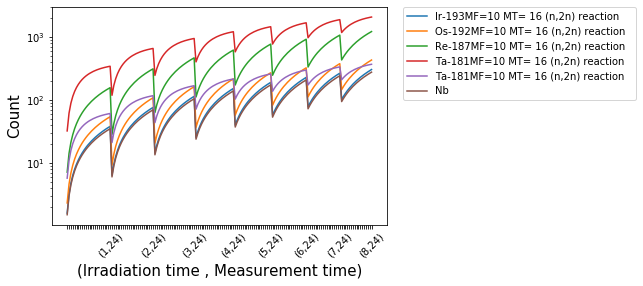

In [4]:
#taとtcの組み合わせでグラフを書く（照射時間が日にちをまたがない）

import numpy as np


tb = 3600#冷却時間
l = 0.5#箔圧[cm]
r = 1.5#箔の半径
N = 6.022*10**23#アボガドロ定数
DT = 5*10**9

tamax = 9
tcmax= 25

count_list = []
foil_list = []

x = []
ticks = []
i = 1
for ta in range(1,tamax):
    for tc in range(1,tcmax):
        if tc >= ta:
            x.append(i)
            i = i + 1
            
            if tc == tcmax-1:
                ticks.append("(" + str(ta) + "," + str(tc) + ")")
            else:
                ticks.append(" ")
            
#             print("(" + str(ta) + str(tc) + ")")
            


for i in range(len(result_list)):
    count_per_list = []
    
    #relativeはとばす------------------------------------------------------------
    if "*" in result_list[i][12]:
        o = "0"
    
    #relatveではないかつエネルギー、半減期が0ではないときに、諸量を計算------------------------------------------
    else:
        if float(result_list[i][11]) != 0:
            if result_list[i][13] != "0":
                

                if "<" in result_list[i][12]:
                    e = ""
                    for k in range(1,len(result_list[i][12])):
                        e = e + result_list[i][12][k]
                elif "~" in result_list[i][12]:
                    e = ""
                    for k in range(1,len(result_list[i][12])):
                        e = e + result_list[i][12][k]
                else:
                    e = float(result_list[i][12])
#                 print(e)
                e = float(e)/100

                a = float(result_list[i][8])#平均原子量
                b = float(result_list[i][7])#存在比
                f = float(result_list[i][15])#Ge検出器効率
                g = float(result_list[i][14])#質量吸収係数
                h = float(result_list[i][10])#平均密度

                #Σσφ
                c = result_list[i][9]
                


                d = ""
                for t in range(len(result_list[i][13])-1):
                    d = d + result_list[i][13][t]
                d = float(d)

                if result_list[i][13][len(result_list[i][13])-1] == "s":
                    d = d
                elif result_list[i][13][len(result_list[i][13])-1] == "m":
                    d = d*60
    #                 print("m")
                elif result_list[i][13][len(result_list[i][13])-1] == "h":
                    d = d*60*60
    #                 print("h")
                elif result_list[i][13][len(result_list[i][13])-1] == "d":
                    d = d*60*60*24
    #                 print("d")
                elif result_list[i][13][len(result_list[i][13])-1] == "y":
                    d = d*60*60*24*365
    #                 print("y")
                    d = float(d)
                for ta in range(1,tamax):
                    for tc in range(1,tcmax):
                        
                        if tc >= ta:
                            count = b * (h*(r*r*3.14)*l)/a * N * c * d/np.log(2) * (1-np.exp(-1*l*h*g))/(l*h*g) * e * f * (1-np.exp(-1*np.log(2)/d*ta*3600)) * np.exp(-1*np.log(2)/d*tb) * (1-np.exp(-1*np.log(2)/d*tc*3600))*DT
                            count_per_list.append(count)
                            
                count_list.append(count_per_list)
                foil_list.append(result_list[i][0]+result_list[i][1])
                            
#                 if count > 20:
#                     print(result_list[i])
                
#                 ta = 8
#                 tc = 8
#                 pa = d/np.log(2) * (1-np.exp(-1*l*h*g))/(l*h*g) * e * f * (1-np.exp(-1*np.log(2)/d*ta*3600)) * np.exp(-1*np.log(2)/d*tb) * (1-np.exp(-1*np.log(2)/d*tc*3600))
#                 print((pa,result_list[i]))
#Nbのカウントリスト------------------------------
Nb_a = 92.90637
Nb_b = 1.0
Nb_c = float("1.429090E-1")
Nb_d = 10.15*24*60*60
Nb_e = 0.9907
Nb_f = float("5.61E-03")
Nb_g = 0.0609
Nb_h = 8.57
count_Nb_list = []

for ta in range(1,tamax):
    for tc in range(1,tcmax):
        if tc >= ta:
            count_Nb = Nb_b * (Nb_h*(r*r*3.14)*l)/Nb_a * N * sigma_reaction_Nb * Nb_d/np.log(2) * (1-np.exp(-1*l*Nb_h*Nb_g))/(l*Nb_h*Nb_g) * Nb_e * Nb_f * (1-np.exp(-1*np.log(2)/Nb_d*ta*3600)) * np.exp(-1*np.log(2)/Nb_d*tb) * (1-np.exp(-1*np.log(2)/Nb_d*tc*3600)) * DT
            count_Nb_list.append(count_Nb)
            print(count_Nb)

# ta = 8
# tc = 8
# pa = Nb_d/np.log(2) * (1-np.exp(-1*l*Nb_h*Nb_g))/(l*Nb_h*Nb_g) * Nb_e * Nb_f * (1-np.exp(-1*np.log(2)/Nb_d*ta*3600)) * np.exp(-1*np.log(2)/Nb_d*tb) * (1-np.exp(-1*np.log(2)/Nb_d*tc*3600))
# print(pa)



for i in range(len(count_list)):
    if count_list[i][len(count_list[i])-1] > count_Nb_list[len(count_Nb_list)-1]:
        plt.plot(x,count_list[i],label =foil_list[i])
        print(count_list[i][len(count_list[i])-1],foil_list[i])
    
#     else:
#         plt.plot(count_list[i])


plt.plot(x,count_Nb_list,label = "Nb")
plt.legend()
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=10)
plt.xticks(rotation=45)
plt.xticks(x, ticks)
plt.xlabel("(Irradiation time , Measurement time)", fontsize = 15)
plt.ylabel("Count", fontsize = 15)
plt.show()





['Ir-193', 'MF=10 MT= 16 (n,2n) reaction  ', 0.0, '7.812540E+6 ', 77, 192, 'Ir', '0.627', '192.217', 1.7057255487165993e-31, '22.4', '295.95827', '28.67', '73.839d', 0.081967601907, 0.01735935327682344]
['Ir-193', 'MF=10 MT= 16 (n,2n) reaction  ', 0.0, '7.812540E+6 ', 77, 192, 'Ir', '0.627', '192.217', 1.7057255487165993e-31, '22.4', '308.45692', '30', '73.840d', 0.08094995946, 0.016518129756189236]
['Ir-193', 'MF=10 MT= 16 (n,2n) reaction  ', 0.0, '7.812540E+6 ', 77, 192, 'Ir', '0.627', '192.217', 1.7057255487165993e-31, '22.4', '316.57091', '82.81', '73.842d', 0.08034546720499999, 0.01583126101579556]
['Ir-193', 'MF=10 MT= 16 (n,2n) reaction  ', 0.0, '7.812540E+6 ', 77, 192, 'Ir', '0.627', '192.217', 1.7057255487165993e-31, '22.4', '468.07152', '47.83', '73.848d', 0.070141008928, 0.008262403127021332]
['Os-192', 'MF=10 MT= 16 (n,2n) reaction  ', 0.0, '7.597800E+6 ', 76, 191, 'Os', '0.4078', '190.23', 1.1795640898431996e-31, '22.6', '129.421', '29', '15.4d', 0.0982756468, 0.0326167629

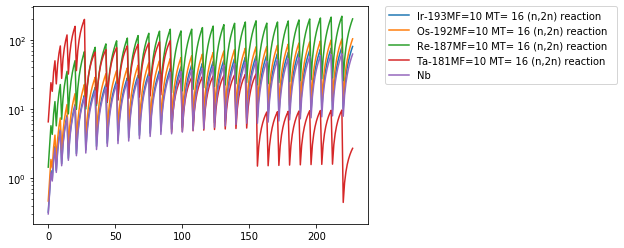

In [5]:
#taとtcの組み合わせでグラフを書く（照射時間が日にちをまたぐ）
# for ta in range(1,33):
#     for tc in range(1,9):
#         if ta >= tc :
#             tb = ta//8*15+1
#             print(ta,tb,tc)
import numpy as np


l = 0.5#箔圧[cm]
r = 1.5#箔の半径
N = 6.022*10**23#アボガドロ定数
DT = 1*10**9

count_list = []
foil_list = []


for i in range(len(result_list)):
    count_per_list = []
    
    #relativeはとばす------------------------------------------------------------
    if "*" in result_list[i][12]:
        o = "0"
    
    #relatveではないかつエネルギー、半減期が0ではないときに、諸量を計算------------------------------------------
    else:
        if float(result_list[i][11]) != 0:
            if result_list[i][13] != "0":
                
                #放出比
                if "<" in result_list[i][12]:
                    e = ""
                    for k in range(1,len(result_list[i][12])):
                        e = e + result_list[i][12][k]
                elif "~" in result_list[i][12]:
                    e = ""
                    for k in range(1,len(result_list[i][12])):
                        e = e + result_list[i][12][k]
                else:
                    e = float(result_list[i][12])
#                 print(e)
                e = float(e)/100

                a = float(result_list[i][8])#平均原子量
                b = float(result_list[i][7])#存在比
                f = float(result_list[i][15])#Ge検出器効率
                g = float(result_list[i][14])#質量吸収係数
                h = float(result_list[i][10])#平均密度

                #Σσφ
                c = result_list[i][9]
                


                d = ""
                for t in range(len(result_list[i][13])-1):
                    d = d + result_list[i][13][t]
                d = float(d)

                if result_list[i][13][len(result_list[i][13])-1] == "s":
                    d = d
                elif result_list[i][13][len(result_list[i][13])-1] == "m":
                    d = d*60
    #                 print("m")
                elif result_list[i][13][len(result_list[i][13])-1] == "h":
                    d = d*60*60
    #                 print("h")
                elif result_list[i][13][len(result_list[i][13])-1] == "d":
                    d = d*60*60*24
    #                 print("d")
                elif result_list[i][13][len(result_list[i][13])-1] == "y":
                    d = d*60*60*24*365
    #                 print("y")
                    d = float(d)
                for ta in range(1,33):
                    for tc in range(1,9):
                        
                        if ta >= tc:
                            tb = ta//8*15+1
                            count = b * (h*(r*r*3.14)*l)/a * N * c * d/np.log(2) * (1-np.exp(-1*l*h*g))/(l*h*g) * e * f * (1-np.exp(-1*np.log(2)/d*ta*3600)) * np.exp(-1*np.log(2)/d*tb*3600) * (1-np.exp(-1*np.log(2)/d*tc*3600))*DT
                            count_per_list.append(count)
                count_list.append(count_per_list)
                foil_list.append(result_list[i][0]+result_list[i][1])
                if count > 20:
                    print(result_list[i])
                
#                 ta = 8
#                 tc = 8
#                 pa = d/np.log(2) * (1-np.exp(-1*l*h*g))/(l*h*g) * e * f * (1-np.exp(-1*np.log(2)/d*ta*3600)) * np.exp(-1*np.log(2)/d*tb) * (1-np.exp(-1*np.log(2)/d*tc*3600))
#                 print((pa,result_list[i]))
#Nbのカウントリスト------------------------------
Nb_a = 92.90637
Nb_b = 1.0
Nb_c = float("1.429090E-1")
Nb_d = 10.15*24*60*60
Nb_e = 0.9907
Nb_f = float("5.61E-03")
Nb_g = 0.0609
Nb_h = 8.57
count_Nb_list = []

for ta in range(1,33):
    for tc in range(1,9):
        if ta >= tc:
            tb = ta//8*15+1
            count_Nb = Nb_b * (Nb_h*(r*r*3.14)*l)/Nb_a * N * sigma_reaction_Nb * Nb_d/np.log(2) * (1-np.exp(-1*l*Nb_h*Nb_g))/(l*Nb_h*Nb_g) * Nb_e * Nb_f * (1-np.exp(-1*np.log(2)/Nb_d*ta*3600)) * np.exp(-1*np.log(2)/Nb_d*tb*3600) * (1-np.exp(-1*np.log(2)/Nb_d*tc*3600)) * DT
            count_Nb_list.append(count_Nb)
#             print(count_Nb)

# ta = 8
# tc = 8
# pa = Nb_d/np.log(2) * (1-np.exp(-1*l*Nb_h*Nb_g))/(l*Nb_h*Nb_g) * Nb_e * Nb_f * (1-np.exp(-1*np.log(2)/Nb_d*ta*3600)) * np.exp(-1*np.log(2)/Nb_d*tb) * (1-np.exp(-1*np.log(2)/Nb_d*tc*3600))
# print(pa)



for i in range(len(count_list)):
    if count_list[i][35] > count_Nb_list[35]:
        plt.plot(count_list[i],label =foil_list[i])
        print(count_list[i][35],foil_list[i])
    
#     else:
#         plt.plot(count_list[i])
plt.plot(count_Nb_list,label = "Nb")
plt.legend()
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=10)
plt.show()



